# Image Translation

This will provide you an introduction image translation formulated as a regression problem using a U-Net model.
Hopefully you will be acqainted with the U-Net model by now. At its core, it's an autoencoder, consisting of an encoder (downsampling) part and a decoder (upsampling) part. The U-Net model has become immensely popular in many image analysis tasks, and one of its main strengths are the skip connections between the encoder and decoder layers which allows the model to capture details at and near the input level resolution. If you've seen U-Nets being used for image segmentation previously, you only need minor adjustments to adapt it to image regression, by changing the loss function and the final activation layer (more on that later).

Below is an overview of the U-Net model architecture with the three different dimensionalities we've explored in the paper (reference): 2D (slice to slice), 2.5D (stack to slice) and 3D (stack to stack).

![U-Net architecture](model.png)

Let's start with some imports. We'll be using the open source U-Net repository ![microDL](https://github.com/czbiohub/microDL) , so we'll import that along with some plotting and other utility packages.

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import importlib
import os
import pprint
import sys

import micro_dl.cli.image_inference as inference
# import micro_dl.cli.metrics_script as metrics
import micro_dl.cli.train_script as train
import micro_dl.cli.preprocess_script as preprocess
import micro_dl.utils.aux_utils as aux_utils
import micro_dl.utils.image_utils as im_utils

# Add module path to sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Setup pretty print
pp = pprint.PrettyPrinter(indent=4)

/Users/jenny.folkesson/Code/microDL


In microDL we'll be using three main modules, preprocessing, training and inference (see imports above). 
The first step is the preprocessing. We have some options like resizing, flatfield correction, creating masks, and tiling.
The data we're working with is already background corrected so we can safely skip that part. We also don't need to resize the images.

We would however like to create masks based on our target data. The reason for that is that we would like to avoid training on background only, that is empty or near empty tiles. A threshold we found reasonable is to make sure that our tiles contain 25% signal or more. We will be using Otsu thresholding *add link* which is a commonly used global thresholding scheme for bimodal distributions.

We would also like to tile our images. The original image size (2048 x 2048 pixels) which is by far too large to be able to fit into memory, and there's repeating structures occurring across the images so we'd be much better of splitting the images into smalles pieces (tiles). An important thing to consider when designing the network is the _receptive field_ *add link here*. With size of the structures we're interested in and using 3 x 3 convolutions we decided to use 256 x 256 pixel tiles.

Usually we run microDL through command line interfaces (CLIs), which is to say we just input commands in the terminal. For each module we specify the path to a config file as a command line argument. Since we're using Jupyter Notebook for this tutorial we will instead load the preprocessing config so we can take a look at it.

In [27]:
config_path = os.path.join(
    module_path,
    'micro_dl/config_preprocess.yml',
)
preproc_config = aux_utils.read_config(config_path)
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 5],
    'flat_field': {'estimate': True},
    'input_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010',
    'masks': {   'channels': [5],
                 'mask_ext': 'png',
                 'mask_type': 'otsu',
                 'str_elem_radius': 3},
    'num_workers': 4,
    'output_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010_train_data',
    'resize': {'resize_3d': False, 'scale_factor': 2},
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [64, 64],
                'tile_size': [256, 256]},
    'verbose': 10}


In [28]:
# There are some things we need to change around here. We're not doing resizing so let's remove that key
if 'resize' in preproc_config:
    preproc_config.pop('resize')
# We're not doing flatfield correction either
if 'flat_field' in preproc_config:
    preproc_config.pop('flat_field')
# We need to change input_dir to point to where our image data is located
preproc_config['input_dir'] = '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010/'
# And where we want to store our preprocessed data
preproc_config['output_dir'] = '/Users/jenny.folkesson/Data/SMS_preprocessed_data/'
# Our VMs have 8 cores so adjust the number of workers
preproc_config['num_workers'] = 8
# Let's look again
pp.pprint(preproc_config)

{   'channel_ids': [0, 1, 5],
    'input_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010/',
    'masks': {   'channels': [5],
                 'mask_ext': 'png',
                 'mask_type': 'otsu',
                 'str_elem_radius': 3},
    'num_workers': 8,
    'output_dir': '/Users/jenny.folkesson/Data/SMS_preprocessed_data/',
    'tile': {   'depths': [1, 1, 1],
                'image_format': 'zyx',
                'mask_depth': 1,
                'min_fraction': 0.25,
                'save_tiled_masks': True,
                'step_size': [64, 64],
                'tile_size': [256, 256]},
    'verbose': 10}


In [29]:
# Now let's break apart our config and also set some other parameters
input_dir = preproc_config['input_dir']
output_dir = preproc_config['output_dir']

# Typically microscopy images are indexed along channels, time, FOV (position) and slice (z)
# index of -1 mean include all indices
slice_ids = -1
if 'slice_ids' in preproc_config:
    slice_ids = preproc_config['slice_ids']
time_ids = -1
if 'time_ids' in preproc_config:
    time_ids = preproc_config['time_ids']
pos_ids = -1
if 'pos_ids' in preproc_config:
    pos_ids = preproc_config['pos_ids']
channel_ids = -1
if 'channel_ids' in preproc_config:
    channel_ids = preproc_config['channel_ids']
# The images are uniform in size
uniform_struct = True
# How many chars an index should be encoded as
int2str_len = 3
# Number of processes to use
num_workers = 4
if 'num_workers' in pp_config:
    num_workers = preproc_config['num_workers']

base_config = {'input_dir': input_dir,
               'output_dir': output_dir,
               'slice_ids': slice_ids,
               'time_ids': time_ids,
               'pos_ids': pos_ids,
               'channel_ids': channel_ids,
               'uniform_struct': uniform_struct,
               'int2strlen': int2str_len,
               'num_workers': num_workers}

# Let's look at the base_config we just generated
pp.pprint(base_config)

{   'channel_ids': [0, 1, 5],
    'input_dir': '/Users/jenny.folkesson/Data/SMS-2018-07-03-18-35-00-0010/',
    'int2strlen': 3,
    'num_workers': 8,
    'output_dir': '/Users/jenny.folkesson/Data/SMS_preprocessed_data/',
    'pos_ids': -1,
    'slice_ids': -1,
    'time_ids': -1,
    'uniform_struct': True}


In [30]:
# Now it's time to do run the preprocessing
preproc_config, runtime = preprocess.pre_process(preproc_config, base_config)
print("Preprocessing took {} seconds".format(runtime))
# Save the final config and run time
preprocess.save_config(preproc_config, runtime)

Preprocessing took 5.512061834335327 seconds


You can navigate to your output_dir and take a look at what was generated. You will find a mask_dir containing masks, a tile_dir containing tiles and JSON file containing the all the information that was used to generated the preprocessed data. Let's take a look at a mask with the image it was generated by next to it.

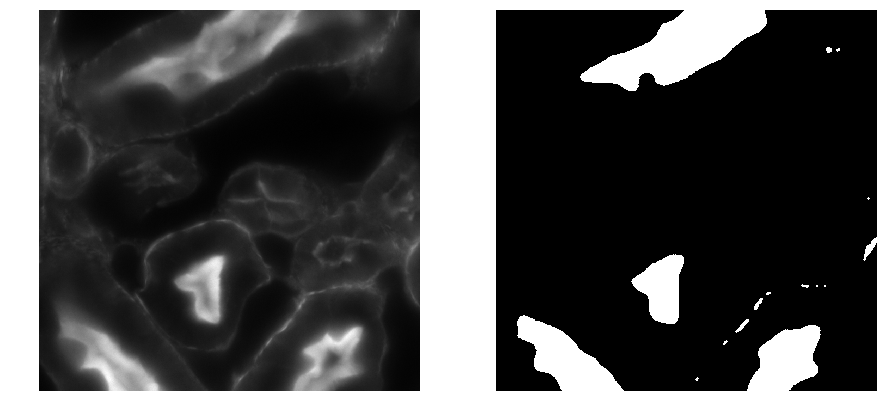

In [43]:
# Our mask channel was 5 (same as our intended target channel)
im_path = os.path.join(preproc_config['input_dir'], 'im_c005_z015_t000_p000.png')
# Our preprocessing script has added a mask_dir. Masked images get assigned a new higher channel idx.
mask_path = os.path.join(preproc_config['masks']['mask_dir'], 'im_c006_z015_t000_p000.png')

# Load images and plot them
im = im_utils.read_image(im_path)

mask = im_utils.read_image(mask_path)
mask = mask.astype(np.uint8)

plt.subplot(121); plt.imshow(im, cmap='gray'); plt.axis('off')
plt.subplot(122); plt.imshow(mask, cmap='gray'); plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()

Now that we've preprocessed our data we're ready to train. 
* Maybe here's a good place to insert birefringence explanation, which channels are what etc*

In [44]:
# Let's load a base 2D training config file and adapt it to our needs
config_path = os.path.join(
    module_path,
    'micro_dl/config.yml',
)
train_config = aux_utils.read_config(config_path)
pp.pprint(train_config)

{   'dataset': {   'data_dir': '/data/anitha/label_free/image_tile_256-256_step_256-256',
                   'height': 256,
                   'input_channels': [3],
                   'preprocess': False,
                   'split_by_column': 'sample_num',
                   'split_ratio': {'test': 0.15, 'train': 0.7, 'val': 0.15},
                   'target_channels': [0],
                   'train_fraction': 0.25,
                   'width': 256},
    'network': {   'activation': {'type': 'relu'},
                   'batch_norm': True,
                   'block_sequence': 'conv-activation-bn',
                   'class': 'UNet3D',
                   'data_format': 'channels_first',
                   'depth': 8,
                   'dropout': 0.2,
                   'filter_size': 3,
                   'final_activation': 'linear',
                   'height': 256,
                   'num_convs_per_block': 2,
                   'num_filters_per_block': [16, 32, 48],
                 